In [1]:
import sys
sys.path.append("../src/")
import numpy as np
import pandas
import json
import ot
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import glob
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

import random
import tqdm
from tqdm import tqdm
import seaborn as sb
import scipy as sp
import topo_util
from topo_util import noisy_circle
import sklearn as sk
import sklearn.decomposition
import math
import pd
import hypernetx as hnx

/home/syz/miniconda3/envs/tpot/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
np.random.seed(42)
data1 = noisy_circle(50, 0.25, 0, 0, 3 )
data2 = noisy_circle(50, 0.25, 8, 0, 5)
data3 = noisy_circle(50, 0.25, 4, 15, 4 )
A = np.concatenate([data1, data2, data3])
data1 = noisy_circle(50, 0.25, 0, 0, 3 )
data2 = noisy_circle(50, 0.25, 7, 0, 4)
data3 = noisy_circle(50, 0.25, 4, 15, 5 )
B = np.concatenate([data1, data2, data3])

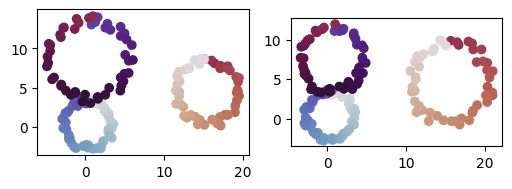

In [3]:
plt.figure(figsize = (6, 3))
plt.subplot(1, 2, 1)
plt.scatter(A[:,1],A[:,0], c = range(A.shape[0]), cmap = 'twilight')
plt.gca().set_aspect('equal', adjustable='box')
plt.subplot(1, 2, 2)
plt.scatter(B[:,1],B[:,0], c = range(B.shape[0]), cmap = 'twilight')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [4]:
def PH(X):
    df = pandas.DataFrame()
    for ii in range(X.shape[1]):
        df['x_{}'.format(ii)] =  X[:,ii]
    df.to_csv("pointcloud.tsv", sep = '\t', index = False)
    !julia ../src/PH.jl 
    with open('PH.json','r') as f:
        dic = json.load(f)
    return dic 
H_all = [PH(x) for x in tqdm([A,B])]
df1 = topo_util.make_dataframe(H_all[0]["barcode"])
df2 = topo_util.make_dataframe(H_all[1]["barcode"])
p_spt = df1.iloc[:, 0:2].to_numpy()
q_spt = df2.iloc[:, 0:2].to_numpy()
G_all = [hnx.Hypergraph({str(i) : k for (i, k) in enumerate(g['representatives'])}) for g in H_all]
y0, w0, v0 = topo_util.process_hg(G_all[0], A.shape[0])
y1, w1, v1 = topo_util.process_hg(G_all[1], B.shape[0])
# similarity with kernel
h = 0.25
K0 = topo_util.get_kernel(A, h)
L0 = topo_util.symmetric_laplacian(K0)
K0 /= K0.sum(-1).reshape(-1, 1)
K1 = topo_util.get_kernel(B, h)
L1 = topo_util.symmetric_laplacian(K1)
K1 /= K1.sum(-1).reshape(-1, 1)
y0_imputed = topo_util.impute_laplacian(y0, L0)
y1_imputed = topo_util.impute_laplacian(y1, L1)
y0_, y1_ = y0, y1; 
y0 = y0_imputed; y1 = y1_imputed;

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:23<00:00, 11.68s/it]


In [140]:
# import topf
# topf_all = [topf.topf(x, return_dict = True, complex_type = 'rips', fixed_num_features = [0, 10]) for x in tqdm([A, B])]
# y0 = topf_all[0][0]
# y1 = topf_all[1][0]
# df1, df2 = [pandas.DataFrame({"b" : x[1]['birth_times'], "d" : x[1]['death_times'], "pers" : np.array(x[1]['death_times']) - np.array(x[1]['birth_times'])}) for x in topf_all]
# p_spt, q_spt = df1.iloc[:, :2].values, df2.iloc[:, :2].values

In [141]:
p, q = pd.augmented_weights(p_spt, q_spt)
C = pd.augmented_cost(p_spt, q_spt)
pi = ot.emd(p, q, C)

In [142]:
import matplotlib.pyplot as plt
import importlib
import numpy as np
from tqdm import tqdm
import hypernetx as hnx
import tpot

In [143]:
C_v0 = sp.spatial.distance.cdist(A, A, metric = "euclidean"); C_v0 /= np.mean(C_v0)
# C_v0 = np.exp(-C_v0)
C_v1 = sp.spatial.distance.cdist(B, B, metric = "euclidean"); C_v1 /= np.mean(C_v1)
# C_v1 = np.exp(-C_v1)
C_pd = pd.augmented_cost(p_spt, q_spt); C_pd /= np.mean(C_pd)

In [144]:
alpha = 0.5
v0 = p
v1 = q
w0 = ot.unif(y0.shape[0])
w1 = ot.unif(y1.shape[0])

importlib.reload(tpot)
pi_s, pi_f, _, = tpot.TPOT(y0, y1, w0, w1, v0, v1,
                          C_v0, C_v1, C_pd, 
                          alpha = alpha, beta = 1, print_iter = 10, iter = 100, 
                          eps_s = 0.003, eps_f = 0.01,
                          solver = "sinkhorn",
                          )

Iteration 0,	 obj = 0.13088529271786364,	 obj_terms = {'coot': 0.03144900093854655, 'ot': 0.0008713292763841503, 'gw': 0.09856496250293295}
Iteration 10,	 obj = 0.028528055038882665,	 obj_terms = {'coot': 0.0048807525293904615, 'ot': 0.0164575874208967, 'gw': 0.007189715088595505}
is_converged, obj = 0.028528056254551355, obj_new = 0.028528056222787562


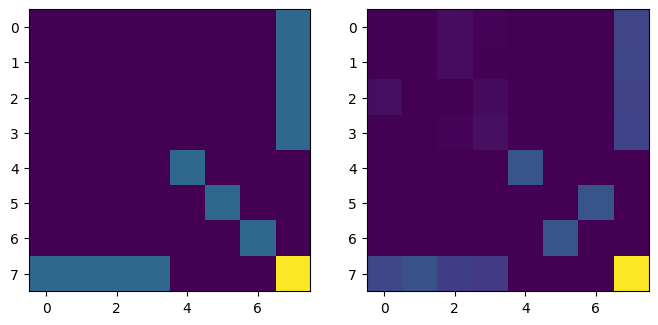

In [188]:
plt.subplot(1, 2, 1)
plt.imshow(pi)
plt.subplot(1, 2, 2)
plt.imshow(pi_f)
plt.savefig('../outputs/matching_matrix_ex4.svg', dpi=300)

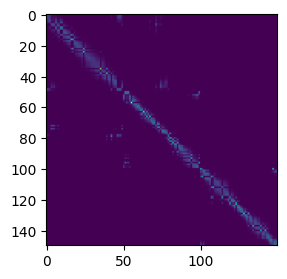

In [146]:
plt.figure(figsize = (3, 3))
plt.imshow(pi_s)

In [147]:
P = (pi_s / pi_s.sum(axis=-1)[:, np.newaxis])
Q = (pi_f[:-1, :-1] / pi_f[:-1, :-1].sum(axis=-1)[:, np.newaxis])
Q_pd = pi[:-1, :-1] / pi[:-1, :-1].sum(axis=-1)[:, np.newaxis]
Q[np.isnan(Q)] = 0
Q_pd[np.isnan(Q_pd)] = 0

/tmp/ipykernel_2301324/3284110093.py:3: RuntimeWarning:

invalid value encountered in divide



In [148]:
len(p_spt), len(q_spt)

(7, 7)

In [149]:
sizes_p = 10 + np.zeros((len(p_spt)))
sizes_q = 10 + np.zeros((len(q_spt)))
sizes_p[-1], sizes_p[-2],sizes_p[-3] = 100,100,100
sizes_q[-1], sizes_q[-2],sizes_q[-3] = 100,100,100

color_p =  np.zeros((len(p_spt)))
color_q =  np.zeros((len(q_spt)))
color_p[-1], color_p[-2],color_p[-3] = 1,2,3
color_q[-1], color_q[-2],color_q[-3] = 1,2,3

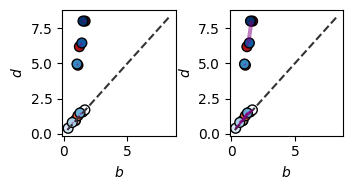

In [203]:
plt.figure(figsize = (3.5, 2))
plt.subplot(1, 2, 1)
# pd.plot_pd_connections(p, q, p_spt, q_spt, pi, color_p, color_q, sizes_p, sizes_q)
pd.plot_pd(p_spt, color = np.arange(p_spt.shape[0]), cmap = 'Reds', plot_diagonal = False)
pd.plot_pd(q_spt, color = np.arange(q_spt.shape[0]), cmap = "Blues")
pd.plot_pd_connections(p, q, p_spt, q_spt, pi)
plt.xlabel("$b$"); plt.ylabel("$d$")
plt.subplot(1, 2, 2)
# pd.plot_pd_connections(p, q, p_spt, q_spt, pi_f, color_p, color_q, sizes_p, sizes_q)
pd.plot_pd(p_spt, color = np.arange(p_spt.shape[0]), cmap = 'Reds', plot_diagonal = False)
pd.plot_pd(q_spt, color = np.arange(q_spt.shape[0]), cmap = "Blues")
pd.plot_pd_connections(p, q, p_spt, q_spt, pi_f)
plt.xlabel("$b$"); plt.ylabel("$d$")
plt.tight_layout()
plt.savefig('../outputs/matching_ex4.svg', dpi=300)

In [174]:
colour_source = list(np.zeros((len(A),)))
colour_target = list(np.zeros((len(A),)))
colour_target_tpot = list(np.zeros((len(A),)))
for l in [4, 5, 6]:
    index_source = np.where((y0_[:, l] >0.5 ))[0]
    for el in index_source:
        colour_source[el] =  l
    l_ = pi[l, :-1].argmax(0)
    index_target = np.where((y1_[:, l_] >0.5 ))[0]
    for el in index_target:
        colour_target[el] = l
    l_ = pi_f[l, :-1].argmax(0)
    index_target = np.where((y1_[:, l_] >0.5 ))[0]
    for el in index_target:
        colour_target_tpot[el] = l

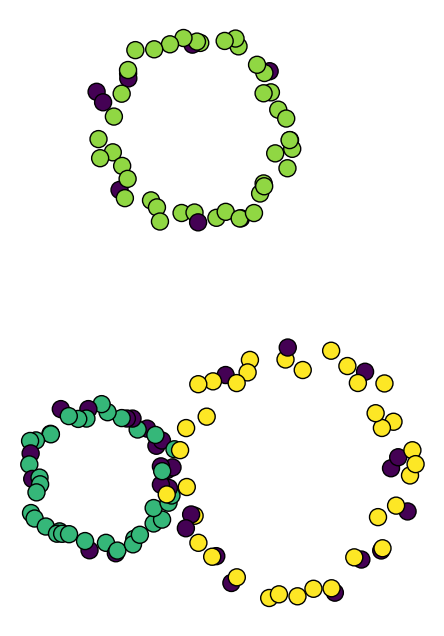

In [179]:
fig = plt.figure()
ax = fig.add_subplot()
scat = ax.scatter(A[:,0],A[:,1],c = colour_source, s=150,edgecolors='black', cmap = 'viridis')
plt.gca().set_aspect('equal')
ax.set_axis_off()
plt.savefig('../outputs/source_ex4.svg', dpi=300)
plt.show()

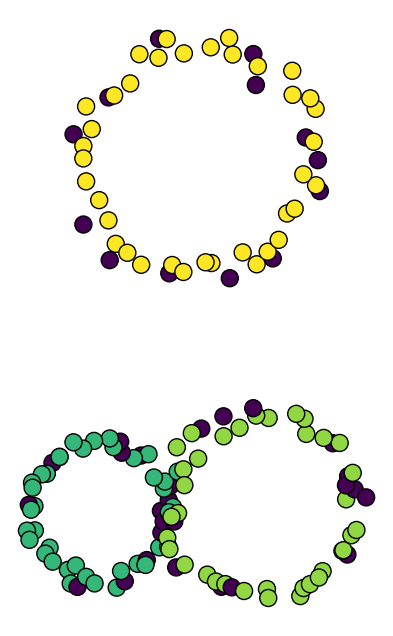

In [180]:
fig = plt.figure()
ax = fig.add_subplot()
scat = ax.scatter(B[:,0],B[:,1],c = colour_target, s=150,edgecolors='black', cmap = "viridis")
plt.gca().set_aspect('equal')
ax.set_axis_off()
plt.savefig('../outputs/target_ex4.svg', dpi=300)
plt.show()

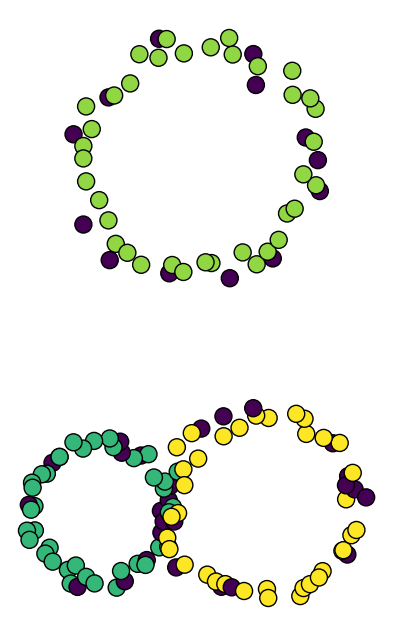

In [181]:
fig = plt.figure()
ax = fig.add_subplot()
scat = ax.scatter(B[:,0],B[:,1],c = colour_target_tpot, s=150,edgecolors='black', cmap = "viridis")
plt.gca().set_aspect('equal')
ax.set_axis_off()
plt.savefig('../outputs/target_ex4_tpot.svg', dpi=300)
plt.show()

In [182]:
one = topo_util.get_eigvec(A[:50])
one = one - min(one)
one = (one/max(one))/3
two = topo_util.get_eigvec(A[50:2*50])
two = two - min(two)
two = 1/3 + (two/max(two))/3
three = topo_util.get_eigvec(A[2*50:3*50])
three = three - min(three)
three = 2/3 + (three/max(three))/3
color_figures = np.concatenate([one,two, three])

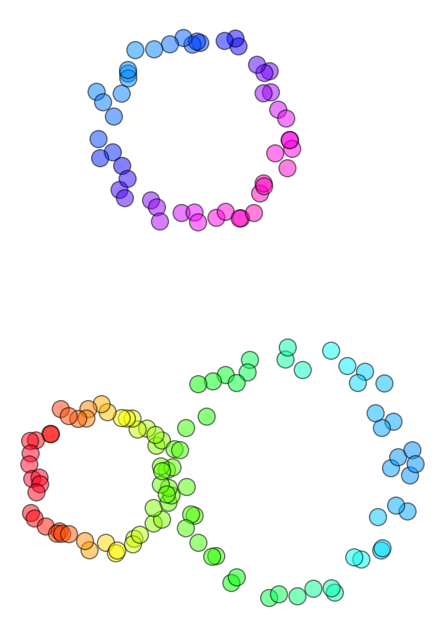

In [186]:
fig = plt.figure()
ax = fig.add_subplot()
scat = ax.scatter(A[:,0],A[:,1],c = color_figures, s=150,edgecolors='black', vmax=1, vmin=0, cmap = "gist_rainbow", alpha = 0.5)
plt.gca().set_aspect('equal')
ax.set_axis_off()
plt.savefig('../outputs/source_ex4_points.svg', dpi=300)

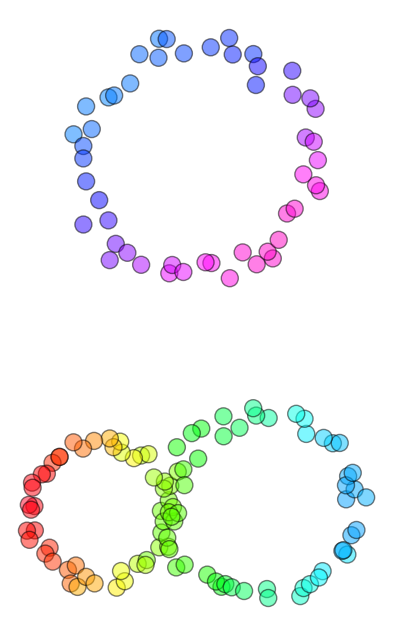

In [187]:
P = pi_s.T / pi_s.sum(axis=0)[:, np.newaxis]
_c = np.matmul(P, color_figures)

fig = plt.figure()
ax = fig.add_subplot()
scat = ax.scatter(B[:,0],B[:,1],c = _c, s=150,edgecolors='black', vmax=1, vmin=0, cmap = "gist_rainbow", alpha = 0.5)
plt.gca().set_aspect('equal')
ax.set_axis_off()
plt.savefig('../outputs/target_ex4_points_tpot.svg', dpi=300)